In [ ]:
!pip install yfinance
# libaries
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import yfinance as yf
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import time

In [ ]:
aapl = yf.Ticker("AAPL")
# get stock info
aapl.info
# get historical market data as df
hist1 = aapl.history(period="max")
hist = hist1['2015-01-01': '2020-12-31']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


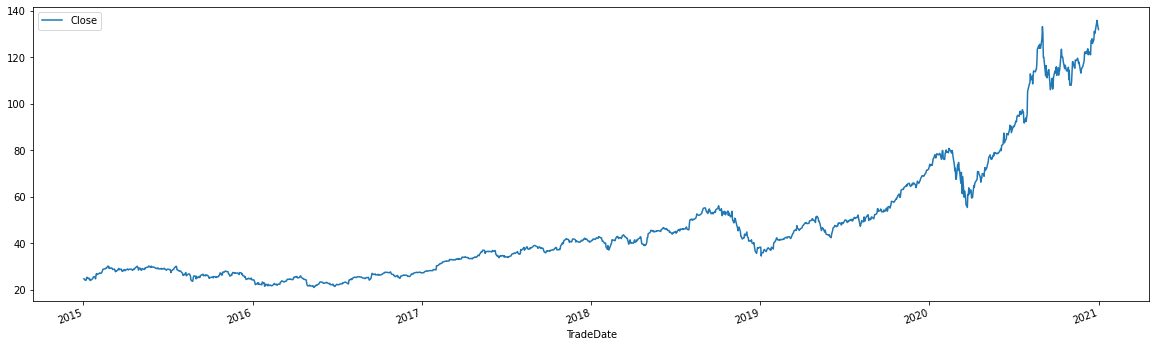

In [ ]:
# Creating a column as date
StockData = hist
StockData['TradeDate']=hist.index

# Plotting the stock prices
%matplotlib inline
StockData.plot(x='TradeDate', y='Close', kind='line', figsize=(20,6), rot=20)

In [ ]:
# Extracting the closing prices of each day
FullData=StockData[['Close']].values
print(FullData[0:5])

# Choosing between Standardization or normalization
#sc = StandardScaler()
sc=MinMaxScaler()

DataScaler = sc.fit(FullData)
X=DataScaler.transform(FullData)
#X=FullData

print('### After Normalization ###')
X[0:5]

[[24.74599075]
 [24.04886436]
 [24.05112648]
 [24.38837624]
 [25.32543564]]
### After Normalization ###


array([[0.03230981],
       [0.02623814],
       [0.02625784],
       [0.02919514],
       [0.03735653]])

In [ ]:
# split into samples
X_samples = list()
y_samples = list()

NumerOfRows = len(X)
TimeSteps=10  # next day's Price Prediction is based on last how many past day's prices

# Iterate thru the values to create combinations
for i in range(TimeSteps , NumerOfRows , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i]
    X_samples.append(x_sample)
    y_samples.append(y_sample)

################################################
# Reshape the Input as a 3D (number of samples, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
print('\n#### Input Data shape ####')
print(X_data.shape)

# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=np.array(y_samples)
y_data=y_data.reshape(y_data.shape[0], 1)
print('\n#### Output Data shape ####')
print(y_data.shape)


#### Input Data shape ####
(1501, 10, 1)

#### Output Data shape ####
(1501, 1)


In [ ]:
# Choosing the number of testing data records
TestingRecords=5

# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]

############################################

# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)
print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)


#### Training Data shape ####
(1496, 10, 1)
(1496, 1)

#### Testing Data shape ####
(5, 10, 1)
(5, 1)


In [ ]:
# Visualizing the input and output being sent to the LSTM model
for inp, out in zip(X_train[0:2], y_train[0:2]):
    print(inp,'--', out)

[[0.03230981]
 [0.02623814]
 [0.02625784]
 [0.02919514]
 [0.03735653]
 [0.03759307]
 [0.03215216]
 [0.03406434]
 [0.03323642]
 [0.02736179]] -- [0.02572557]
[[0.02623814]
 [0.02625784]
 [0.02919514]
 [0.03735653]
 [0.03759307]
 [0.03215216]
 [0.03406434]
 [0.03323642]
 [0.02736179]
 [0.02572557]] -- [0.03110732]


In [ ]:
# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

Number of TimeSteps: 10
Number of Features: 1


In [ ]:
# Initialising the RNN
regressor = Sequential()

# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))

# Adding the Second Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))

# Adding the Second Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))


# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

##################################################

import time
# Measuring the time taken by the model to train
StartTime=time.time()

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)

EndTime=time.time()
print("## Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes ##')

Epoch 1/100
300/300 [==============================] - 9s 15ms/step - loss: 0.0158
Epoch 2/100
300/300 [==============================] - 4s 15ms/step - loss: 6.3186e-04
Epoch 3/100
300/300 [==============================] - 4s 15ms/step - loss: 6.6230e-04
Epoch 4/100
300/300 [==============================] - 5s 15ms/step - loss: 5.6016e-04
Epoch 5/100
300/300 [==============================] - 4s 15ms/step - loss: 5.8337e-04
Epoch 6/100
300/300 [==============================] - 4s 15ms/step - loss: 5.3372e-04
Epoch 7/100
300/300 [==============================] - 4s 15ms/step - loss: 5.4032e-04
Epoch 8/100
300/300 [==============================] - 4s 15ms/step - loss: 5.4167e-04
Epoch 9/100
300/300 [==============================] - 5s 15ms/step - loss: 4.7776e-04
Epoch 10/100
300/300 [==============================] - 5s 15ms/step - loss: 4.7349e-04
Epoch 11/100
300/300 [==============================] - 4s 15ms/step - loss: 5.3101e-04
Epoch 12/100
300/300 [=======================

Accuracy: 98.87610361948367


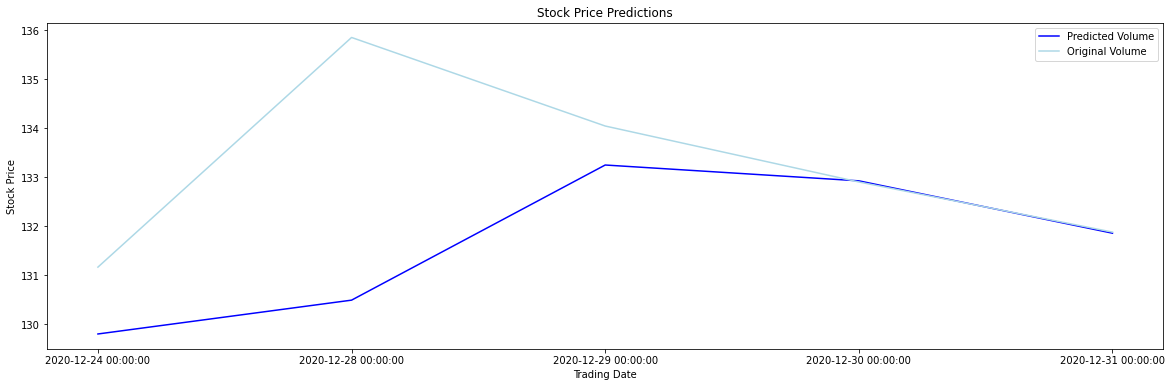

In [ ]:
# Making predictions on test data
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)

# Getting the original price values for testing data
orig=y_test
orig=DataScaler.inverse_transform(y_test)

# Accuracy of the predictions
print('Accuracy:', 100 - (100*(abs(orig-predicted_Price)/orig)).mean())

plt.plot(predicted_Price, color = 'blue', label = 'Predicted Volume')
plt.plot(orig, color = 'lightblue', label = 'Original Volume')

plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.xticks(range(TestingRecords), StockData.tail(TestingRecords)['TradeDate'])
plt.ylabel('Stock Price')

plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(6)
plt.show()

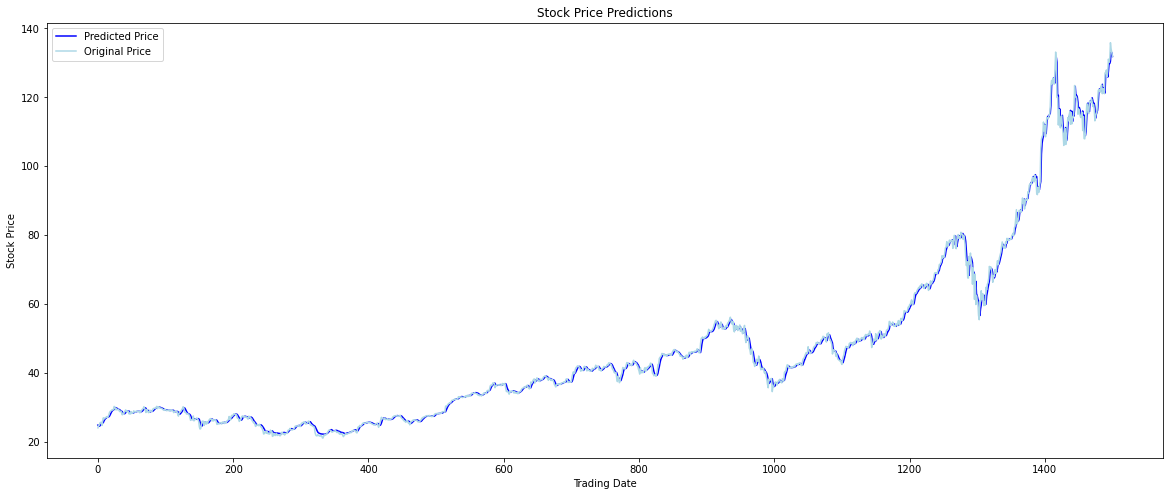

In [ ]:
# Generating predictions on full data
TrainPredictions=DataScaler.inverse_transform(regressor.predict(X_train))
TestPredictions=DataScaler.inverse_transform(regressor.predict(X_test))

FullDataPredictions=np.append(TrainPredictions, TestPredictions)
FullDataOrig=FullData[TimeSteps:]

# plotting the full data
plt.plot(FullDataPredictions, color = 'blue', label = 'Predicted Price')
plt.plot(FullDataOrig , color = 'lightblue', label = 'Original Price')


plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.ylabel('Stock Price')
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()

In [ ]:
bb = StockData['Close'][-15:-5].values

In [ ]:
# Last 10 days prices
Last10Days=np.array(bb)

# Normalizing the data just like we did for training the model
Last10Days=DataScaler.transform(Last10Days.reshape(-1,1))

# Changing the shape of the data to 3D
# Choosing TimeSteps as 10 because we have used the same for training
NumSamples=1
TimeSteps=10
NumFeatures=1
Last10Days=Last10Days.reshape(NumSamples,TimeSteps,NumFeatures)

#############################

# Making predictions on data
predicted_Price = regressor.predict(Last10Days)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
predicted_Price

array([[22.782593, 14.945258, 19.02478 , 17.907486, 24.65534 ]],
      dtype=float32)

In [ ]:
#Data Preparation for Multi Step LSTM

In [ ]:
# Multi step data preparation

# split into samples
X_samples = list()
y_samples = list()

NumerOfRows = len(X)
TimeSteps=10  # next few day's Price Prediction is based on last how many past day's prices
FutureTimeSteps=5 # How many days in future you want to predict the prices

# Iterate thru the values to create combinations
for i in range(TimeSteps , NumerOfRows-FutureTimeSteps , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i:i+FutureTimeSteps]
    X_samples.append(x_sample)
    y_samples.append(y_sample)

################################################

# Reshape the Input as a 3D (samples, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
print('### Input Data Shape ###') 
print(X_data.shape)

# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=np.array(y_samples)
print('### Output Data Shape ###') 
print(y_data.shape)

### Input Data Shape ###
(1496, 10, 1)
### Output Data Shape ###
(1496, 5, 1)


In [ ]:
# Choosing the number of testing data records
TestingRecords=1

# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]

#############################################
# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)

print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)


#### Training Data shape ####
(1495, 10, 1)
(1495, 5, 1)

#### Testing Data shape ####
(1, 10, 1)
(1, 5, 1)


In [ ]:
# Visualizing the input and output being sent to the LSTM model
# Based on last 10 days prices we are learning the next 5 days of prices
for inp, out in zip(X_train[0:2], y_train[0:2]):
    print(inp)
    print('====>')
    print(out)
    print('#'*20)

[[0.03230981]
 [0.02623814]
 [0.02625784]
 [0.02919514]
 [0.03735653]
 [0.03759307]
 [0.03215216]
 [0.03406434]
 [0.03323642]
 [0.02736179]]
====>
[[0.02572557]
 [0.03110732]
 [0.03274352]
 [0.03836187]
 [0.0395053 ]]
####################
[[0.02623814]
 [0.02625784]
 [0.02919514]
 [0.03735653]
 [0.03759307]
 [0.03215216]
 [0.03406434]
 [0.03323642]
 [0.02736179]
 [0.02572557]]
====>
[[0.03110732]
 [0.03274352]
 [0.03836187]
 [0.0395053 ]
 [0.03974184]]
####################


In [ ]:
# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

Number of TimeSteps: 10
Number of Features: 1


In [ ]:
# Initialising the RNN
regressor = Sequential()

# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))


# Adding the Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))

# Adding the Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))


# Adding the output layer
# Notice the number of neurons in the dense layer is now the number of future time steps 
# Based on the number of future days we want to predict
regressor.add(Dense(units = FutureTimeSteps))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

###################################################################


# Measuring the time taken by the model to train
StartTime=time.time()

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)

EndTime=time.time()
print("############### Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes #############')

In [ ]:
nsamples, nx, ny = y_test.shape
y_test = y_test.reshape((nsamples,nx*ny))

In [80]:
# Making predictions on test data
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
print('#### Predicted Prices ####')
print(predicted_Price)

# Getting the original price values for testing data
orig=y_test
orig=DataScaler.inverse_transform(y_test)
print('\n#### Original Prices ####')
print(orig)

#### Predicted Prices ####
[[126.7295   127.39412  126.684044 128.2207   127.4971  ]]

#### Original Prices ####
[[130.15760803 131.16140747 135.85250854 134.0436554  132.9006958 ]]


In [ ]:
mse=mean_squared_error(orig, predicted_Price)
mae=mean_absolute_error(orig, predicted_Price)
mape=mean_absolute_percentage_error(orig, predicted_Price)
print('MSE:  ', mse, '\nMAE:  ', mae,'\nMAPE: ', mape)

MSE:   39.380071516684254 
MAE:   5.9239013671875 
MAPE:  0.04438028180147517


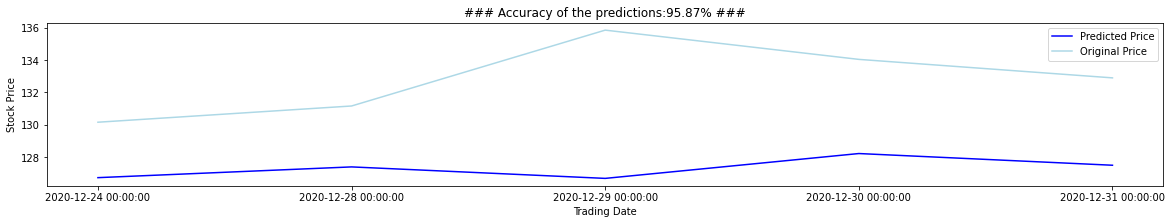

In [81]:
for i in range(len(orig)):
    Prediction=predicted_Price[i]
    Original=orig[i]
    
    # Visualising the results
    plt.plot(Prediction, color = 'blue', label = 'Predicted Price')
    plt.plot(Original, color = 'lightblue', label = 'Original Price')

    plt.title('### Accuracy of the predictions:'+ str(100 - (100*(abs(Original-Prediction)/Original)).mean().round(2))+'% ###')
    plt.xlabel('Trading Date')
    
    startDateIndex=(FutureTimeSteps*TestingRecords)-FutureTimeSteps*(i+1)
    endDateIndex=(FutureTimeSteps*TestingRecords)-FutureTimeSteps*(i+1) + FutureTimeSteps
    TotalRows=StockData.shape[0]

    plt.xticks(range(FutureTimeSteps), StockData.iloc[TotalRows-endDateIndex : TotalRows-(startDateIndex) , :]['TradeDate'])
    plt.ylabel('Stock Price')

    plt.legend()
    fig=plt.gcf()
    fig.set_figwidth(20)
    fig.set_figheight(3)
    plt.show()

In [79]:
# Making predictions on test data
Last10DaysPrices=np.array(FullData[-15:-5])

# Reshaping the data to (-1,1 )because its a single entry
Last10DaysPrices=Last10DaysPrices.reshape(-1, 1)

# Scaling the data on the same level on which model was trained
X_test=DataScaler.transform(Last10DaysPrices)

NumberofSamples=1
TimeSteps=X_test.shape[0]
NumberofFeatures=X_test.shape[1]
# Reshaping the data as 3D input
X_test=X_test.reshape(NumberofSamples,TimeSteps,NumberofFeatures)

# Generating the predictions for next 5 days
Next5DaysPrice = regressor.predict(X_test)

# Generating the prices in original scale
Next5DaysPrice = DataScaler.inverse_transform(Next5DaysPrice)
Next5DaysPrice

array([[126.7295  , 127.39412 , 126.684044, 128.2207  , 127.4971  ]],
      dtype=float32)